<a href="https://colab.research.google.com/github/freida20git/child-age-classification/blob/main/FocalLoss_splits_inference_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Pytorch & other libraries
%pip install "torch==2.5.0" "torchvision==0.20.0"
%pip install "setuptools<71.0.0" scikit-learn

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8"

# ModernBERT is not yet available in an official release, so we need to install it from github
%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch

# Split1:

In [ ]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
from datasets import load_dataset
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split1.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split1.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split1.csv')
                       })

# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

In [ ]:
#Recompute class_weights if neeeded(here division is same over all splits so no need)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss



In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [ ]:


trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [ ]:
# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

trainer.train()

In [ ]:

#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

for param in model.bert.parameters():
    param.requires_grad = True

trainer.args.learning_rate = 2e-5 # use lower learning rate (e.g., 2e-5) for stability
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.438900,0.419442,0.548052,0.459210
2,0.424500,0.402982,0.561039,0.476876
3,0.406400,0.398868,0.555844,0.488377
4,0.399800,0.394174,0.563636,0.529204
5,0.387100,0.411865,0.527273,0.492063
6,0.375800,0.373592,0.579221,0.548115
7,0.366500,0.355080,0.607792,0.558379
8,0.352800,0.346382,0.623377,0.575221
9,0.340200,0.340831,0.620779,0.595455
10,0.332800,0.340495,0.605195,0.575027


TrainOutput(global_step=1380, training_loss=0.33007676083108656, metrics={'train_runtime': 39.3053, 'train_samples_per_second': 2230.742, 'train_steps_per_second': 140.439, 'total_flos': 27857762549760.0, 'train_loss': 0.33007676083108656, 'epoch': 20.0})

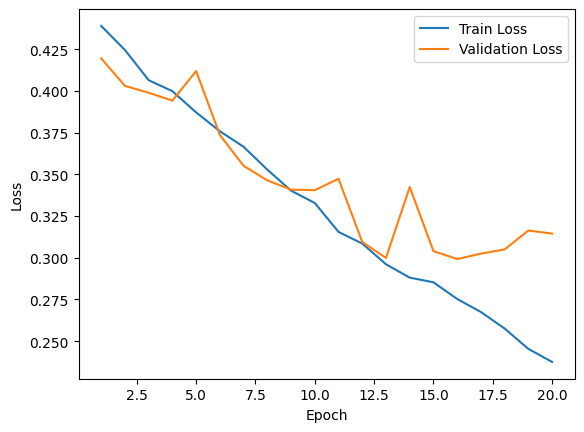

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#validation:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6597402597402597
F1: 0.647796773220502
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       109
           1       0.43      0.33      0.37       101
           2       0.75      0.75      0.75       175

    accuracy                           0.66       385
   macro avg       0.62      0.63      0.62       385
weighted avg       0.64      0.66      0.65       385



In [ ]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6828571428571428
F1: 0.6775916024209186
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       102
           1       0.46      0.40      0.43        92
           2       0.78      0.81      0.79       156

    accuracy                           0.68       350
   macro avg       0.65      0.65      0.65       350
weighted avg       0.67      0.68      0.68       350



In [ ]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split1_model")
metrics_full = trainer.evaluate(tokenized_datasets['validation'])
print("Full validation metrics:", metrics_full)
metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full test metrics:", metrics_full)


Full validation metrics: {'eval_loss': 0.2992309033870697, 'eval_accuracy': 0.6597402597402597, 'eval_f1': 0.647796773220502, 'eval_runtime': 0.2819, 'eval_samples_per_second': 1365.91, 'eval_steps_per_second': 88.695, 'epoch': 20.0}
Full test metrics: {'eval_loss': 0.28497180342674255, 'eval_accuracy': 0.6828571428571428, 'eval_f1': 0.6775916024209186, 'eval_runtime': 0.2181, 'eval_samples_per_second': 1605.057, 'eval_steps_per_second': 100.889, 'epoch': 20.0}


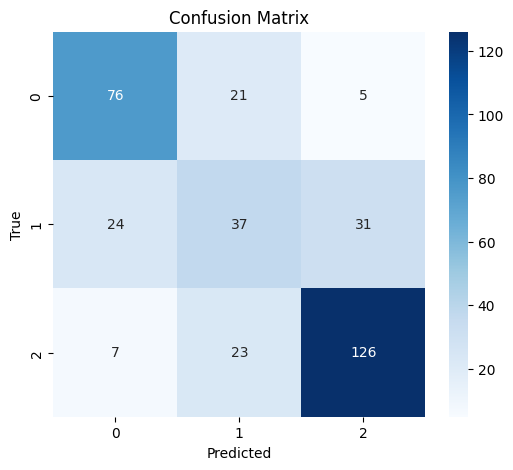

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#split 2

In [ ]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

from transformers import AutoConfig, AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split2.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split2.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split2.csv')
                       })

# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True
trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.527500,0.494822,0.272997,0.160734
2,0.485600,0.469453,0.495549,0.331682
3,0.478600,0.465144,0.498516,0.332344
4,0.471400,0.462344,0.498516,0.332344
5,0.470700,0.461571,0.498516,0.332344
6,0.473200,0.460329,0.498516,0.332344
7,0.469900,0.458124,0.498516,0.331686
8,0.468600,0.457066,0.498516,0.331686
9,0.469600,0.456335,0.498516,0.331686
10,0.466600,0.454208,0.498516,0.331686


TrainOutput(global_step=4968, training_loss=0.45691072268954414, metrics={'train_runtime': 59.5122, 'train_samples_per_second': 1470.624, 'train_steps_per_second': 92.754, 'total_flos': 100104937979904.0, 'train_loss': 0.45691072268954414, 'epoch': 72.0})

In [ ]:
#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

for param in model.bert.parameters():
    param.requires_grad = True

trainer.args.learning_rate = 2e-5 # use lower learning rate (e.g., 2e-5) for stability
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.439900,0.418516,0.587537,0.521181
2,0.425000,0.398285,0.593472,0.516211
3,0.416100,0.382271,0.599407,0.524771
4,0.398100,0.377041,0.617211,0.565827
5,0.389800,0.361865,0.623145,0.577936
6,0.370900,0.359208,0.626113,0.588820
7,0.357800,0.342405,0.632047,0.586911
8,0.340400,0.334284,0.646884,0.612710
9,0.329400,0.327430,0.682493,0.656516
10,0.315000,0.319119,0.673591,0.652144


TrainOutput(global_step=1380, training_loss=0.31587297259897423, metrics={'train_runtime': 38.163, 'train_samples_per_second': 2293.322, 'train_steps_per_second': 144.643, 'total_flos': 27806927216640.0, 'train_loss': 0.31587297259897423, 'epoch': 20.0})

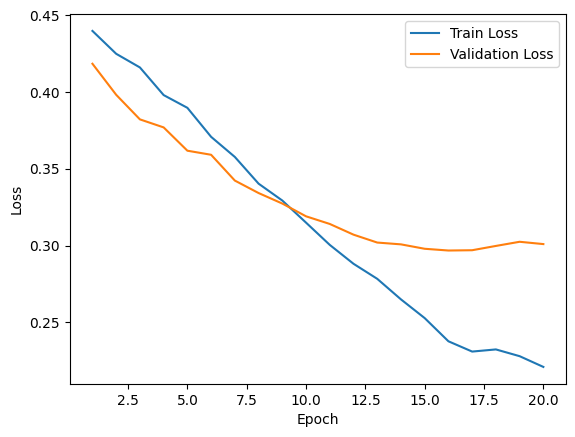

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#validation:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6943620178041543
F1: 0.6810003733679367
              precision    recall  f1-score   support

           0       0.73      0.63      0.68        83
           1       0.47      0.37      0.42        86
           2       0.76      0.89      0.82       168

    accuracy                           0.69       337
   macro avg       0.65      0.63      0.64       337
weighted avg       0.68      0.69      0.68       337



In [ ]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.675
F1: 0.6561612768172767
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       123
           1       0.48      0.32      0.38       110
           2       0.69      0.89      0.78       167

    accuracy                           0.68       400
   macro avg       0.65      0.64      0.63       400
weighted avg       0.66      0.68      0.66       400



In [ ]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split2_model")
metrics_full = trainer.evaluate(tokenized_datasets['validation'])
print("Full validation metrics:", metrics_full)
metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full test metrics:", metrics_full)

Full validation metrics: {'eval_loss': 0.29683539271354675, 'eval_accuracy': 0.6943620178041543, 'eval_f1': 0.6810003733679367, 'eval_runtime': 0.1858, 'eval_samples_per_second': 1813.294, 'eval_steps_per_second': 118.375, 'epoch': 20.0}
Full test metrics: {'eval_loss': 0.29819655418395996, 'eval_accuracy': 0.675, 'eval_f1': 0.6561612768172767, 'eval_runtime': 0.2026, 'eval_samples_per_second': 1974.166, 'eval_steps_per_second': 123.385, 'epoch': 20.0}


# Split3

In [ ]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

from transformers import AutoConfig, AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

def tokenize_function(examples):
    return tokenizer(
        examples["child_text"],
        padding="max_length",  # pad to max_length
        truncation=True,       # truncate longer text
        max_length=512          # adjust if needed
    )

import os
from datasets import load_dataset
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split3.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split3.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split3.csv')
                       })
# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True
trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.486300,0.473052,0.483029,0.397820
2,0.462100,0.472429,0.415144,0.257909
3,0.465000,0.472414,0.409922,0.247221
4,0.461900,0.472507,0.404700,0.236232
5,0.464200,0.471965,0.404700,0.236232
6,0.455900,0.471309,0.404700,0.236232
7,0.460600,0.468921,0.407311,0.241765
8,0.462100,0.468486,0.404700,0.236624
9,0.458700,0.468091,0.404700,0.236624
10,0.457600,0.466173,0.404700,0.240968


TrainOutput(global_step=4554, training_loss=0.4494750165708975, metrics={'train_runtime': 55.132, 'train_samples_per_second': 1588.915, 'train_steps_per_second': 100.123, 'total_flos': 91846738114560.0, 'train_loss': 0.4494750165708975, 'epoch': 66.0})

In [ ]:
#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

for param in model.bert.parameters():
    param.requires_grad = True

trainer.args.learning_rate = 2e-5 # use lower learning rate (e.g., 2e-5) for stability
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.441200,0.431184,0.548303,0.461559
2,0.416700,0.421096,0.532637,0.450462
3,0.408100,0.406563,0.566580,0.477944
4,0.393400,0.391987,0.561358,0.515421
5,0.382300,0.380620,0.556136,0.500439
6,0.364100,0.371524,0.569191,0.532284
7,0.356100,0.360213,0.608355,0.573134
8,0.345600,0.351085,0.597911,0.560724
9,0.326300,0.347019,0.610966,0.581723
10,0.314900,0.340657,0.616188,0.596194


TrainOutput(global_step=1725, training_loss=0.30023585278054943, metrics={'train_runtime': 48.2024, 'train_samples_per_second': 1817.339, 'train_steps_per_second': 114.517, 'total_flos': 34790431104000.0, 'train_loss': 0.30023585278054943, 'epoch': 25.0})

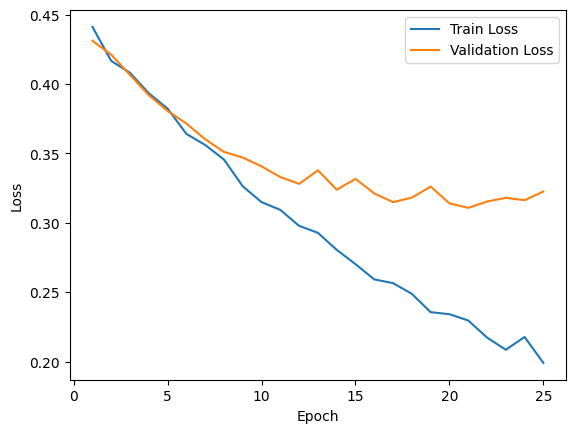

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split3_model")

metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full model metrics:", metrics_full)


Full model metrics: {'eval_loss': 0.25442636013031006, 'eval_accuracy': 0.7053824362606232, 'eval_f1': 0.6903063260726826, 'eval_runtime': 0.2516, 'eval_samples_per_second': 1402.942, 'eval_steps_per_second': 91.41, 'epoch': 25.0}


In [ ]:
#valid:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6292428198433421
F1: 0.6278856576295324
              precision    recall  f1-score   support

           0       0.79      0.64      0.70       127
           1       0.38      0.37      0.37       102
           2       0.68      0.79      0.73       154

    accuracy                           0.63       383
   macro avg       0.61      0.60      0.60       383
weighted avg       0.64      0.63      0.63       383



In [ ]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.7053824362606232
F1: 0.6903063260726826
              precision    recall  f1-score   support

           0       0.78      0.85      0.81        81
           1       0.54      0.38      0.45       103
           2       0.73      0.83      0.78       169

    accuracy                           0.71       353
   macro avg       0.68      0.69      0.68       353
weighted avg       0.69      0.71      0.69       353



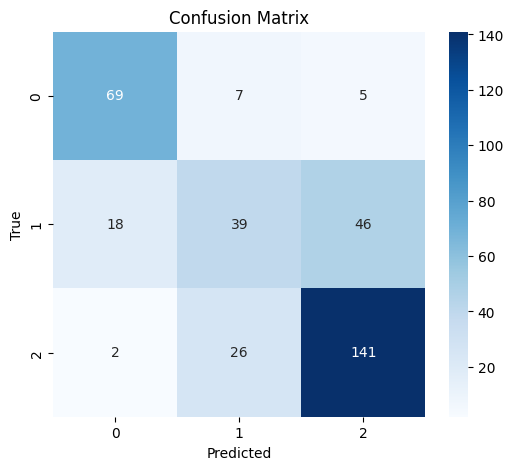

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


AVEREGE:
| Metric   | Split 1 | Split 2 | Split 3 | **Mean**   |
| -------- | ------- | ------- | ------- | ---------- |
| Accuracy | 0.6829  | 0.6750  | 0.7054  | **0.6877** |
| F1 score | 0.6776  | 0.6562  | 0.6903  | **0.6747** |
